# Бэггинг
(bagging, сокр. от bootstrap aggregating)  — метод построения ансамбля, в котором каждый базовый алгоритм принадлежит одному и тому же семейству. При этом каждый базовый алгоритм обучается на своей собственной уникальной подвыборке, составленной из исходных данных. Обучение происходит параллельно и независимо, а финальный результат лишь агрегируется.


Импортируем все необходимые для занятия библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

Загрузим тренировочный датасет и попробуем решить задачу классификации рукописного текста:

In [2]:
iris_dataset = load_iris()
X = iris_dataset.data
y = iris_dataset.target

dataset = load_digits()
X, y = dataset['data'], dataset['target']

n_features = np.shape(X)[1]


Тренировочный датасет состоит из рукопичных чисел, представленных в виде изображений размером 8*8 пикселей (64 признака). Отрисуем один элемент массива на выбор:

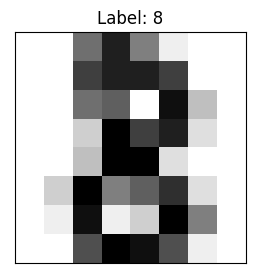

In [3]:
def plot_number_by_data(img_data, label):
    plt.figure(1, figsize=(3, 3))
    plt.imshow(img_data.reshape((8,8)), cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Label: {label}")
    plt.show()

def plot_number_by_index(ind):
    dt = X[ind]
    label = y[ind]
    plot_number_by_data(dt, label)

plot_number_by_index(8)

Посмотрим на то, как работает бэггинг над решающими деревьями.

Для оценки качетсва обучения будем использовать функцию кросс-валидации. Она позволяет построить неколько моделей на различных подвыборках исходных данных, за итоговый результат принимается среднее значение


In [4]:
def get_accuracy(clf, X, y, cv=20):
    return cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()

Для начала построим одно решающее дерево

In [5]:
tree = DecisionTreeClassifier(random_state=37)
print("Decision tree:", get_accuracy(tree, X, y))

Decision tree: 0.7841303002166511


Отрисуем часть изображений для которых прогноз оказался ложным:

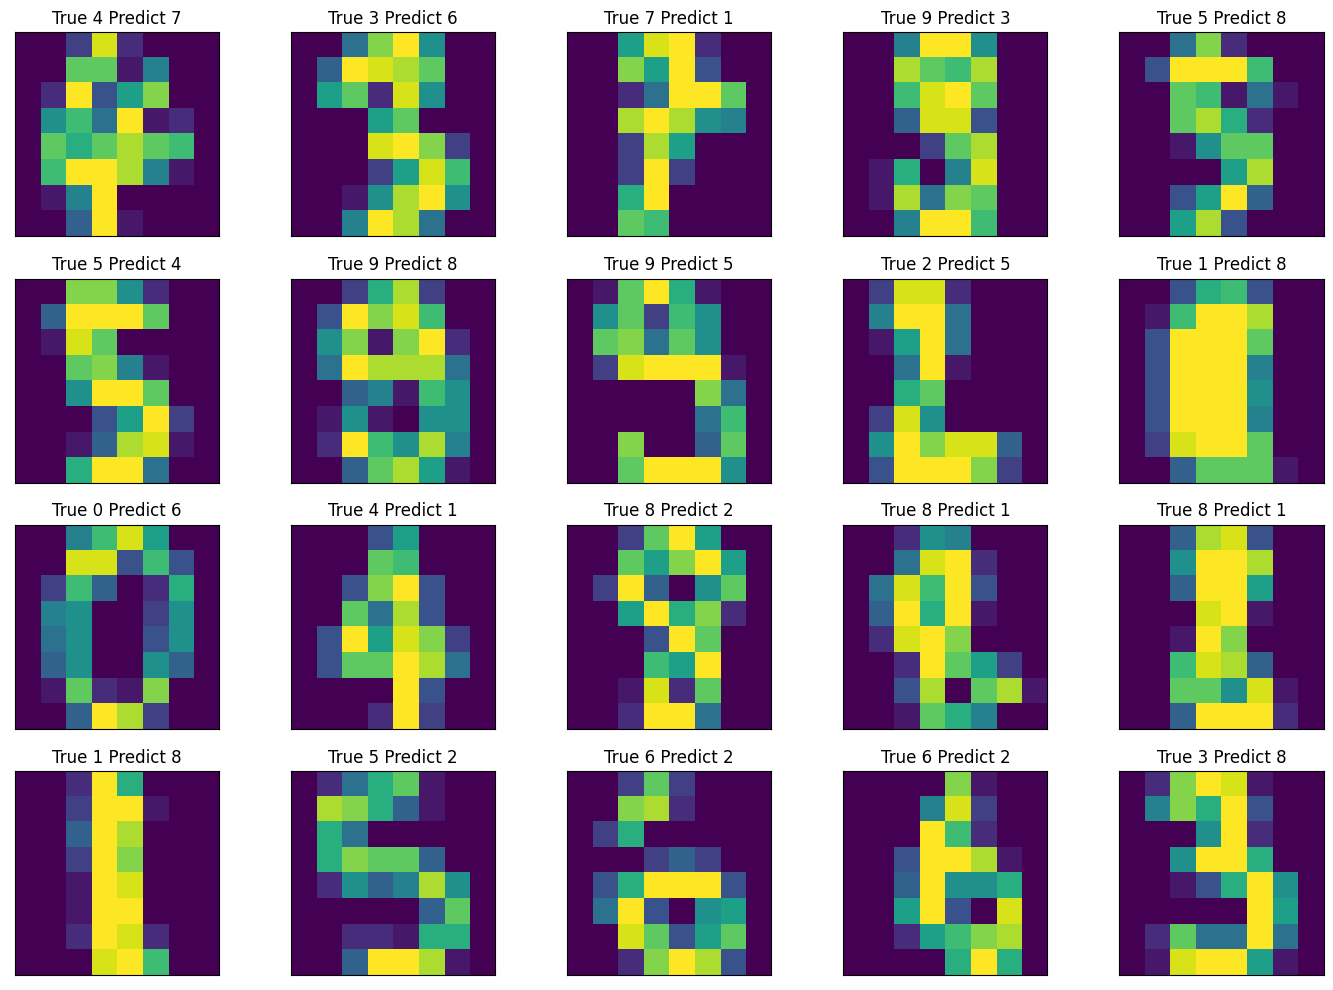

In [6]:
from sklearn.model_selection import train_test_split

def plot_invalid_labels(estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_test)
    
    fig=plt.figure(figsize=(15, 10))
    columns = 5
    rows = 4
    j = 1
    for i in np.arange(len(predict)):
        p = predict[i]
        a = y_test[i]
        if p != a:
            if j <= rows*columns:
                img = X_test[i].reshape((8,8))
                fig.add_subplot(rows, columns, j)
                plt.imshow(img)
                plt.xticks([])
                plt.yticks([])
                fig.tight_layout() 
                plt.title(f"True {a} Predict {p}")
                j+=1
    plt.show()

plot_invalid_labels(tree) 

Как можно заметить, алгоритму не удалось распознать часть изображений, попробуем исправить ситуацию с помощью бэггинга:
для этого необходимо обернуть исходный классификатор в BaggingClassifier. Будем использовать комбинацию из 100 решающих деревьев

In [7]:
bagging_trees = BaggingClassifier(tree, random_state=11,  n_estimators=200)
print("Decision tree bagging:", get_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.9081971525843391


Можно заметить, что композиция решающих деревьев показала лучший результат. Это связано с тем, что в случае бэггинга алгоритм с помощью голосования выбирает оптимальное решение. В случае применения отдельного дерева - результат может сильно меняться в зависимости от входных данных

Так же стоит отметить, что построенная композиция все же немного коррелирована, так как все деревья обучаются на одних и тех же признаках. Добавим параметр max_features - который регулирует количетсво признаков на которых будет обучаться каждый базовый алгоритм (Random Subspaces)

Корень из числа признаков — часто используемая эвристика в задачах классификации. В задачах регрессии же часто берут число признаков, делённое на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков, добиваясь лучшего качества на кросс-валидации.

In [8]:
bagging_trees = BaggingClassifier(tree, random_state=11, n_estimators=100, max_features=int(np.sqrt(n_features)))
print("Decision tree bagging:", get_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.9232265552460539


Качество обучения возросло, теперь можно попробовать задать ограничение на кол-во признаков, используемых при построении ветвлений каждого отдельного дерева внутри композиции. Для этого достаочно задать значение параметра max_features внутри DecisionTreeClassifier

In [9]:
tree = DecisionTreeClassifier(random_state=37, max_features=int(np.sqrt(n_features)))
bagging_trees = BaggingClassifier(tree, random_state=11, n_estimators=100)
print("Decision tree bagging:", get_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.937137109254101


Аналогичным образом работает алгоритм Случайного Леса (Random Forest): он обучает набор деревьев (параметр n_esimators), каждое из которых обучается на подмножестве признаков (Random Subspaces) и на подмножестве объектов (bootstrap):

In [10]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    max_features=int(np.sqrt(n_features)),
    max_depth=30)
print("Random Forest:", get_accuracy(random_forest, X, y))

Random Forest: 0.9354719900959456


# Влияние настроечных параемтров RF на качество обучения

Посмотрим как зависит качетсво обучения в зависимости от количества решающих деревьев

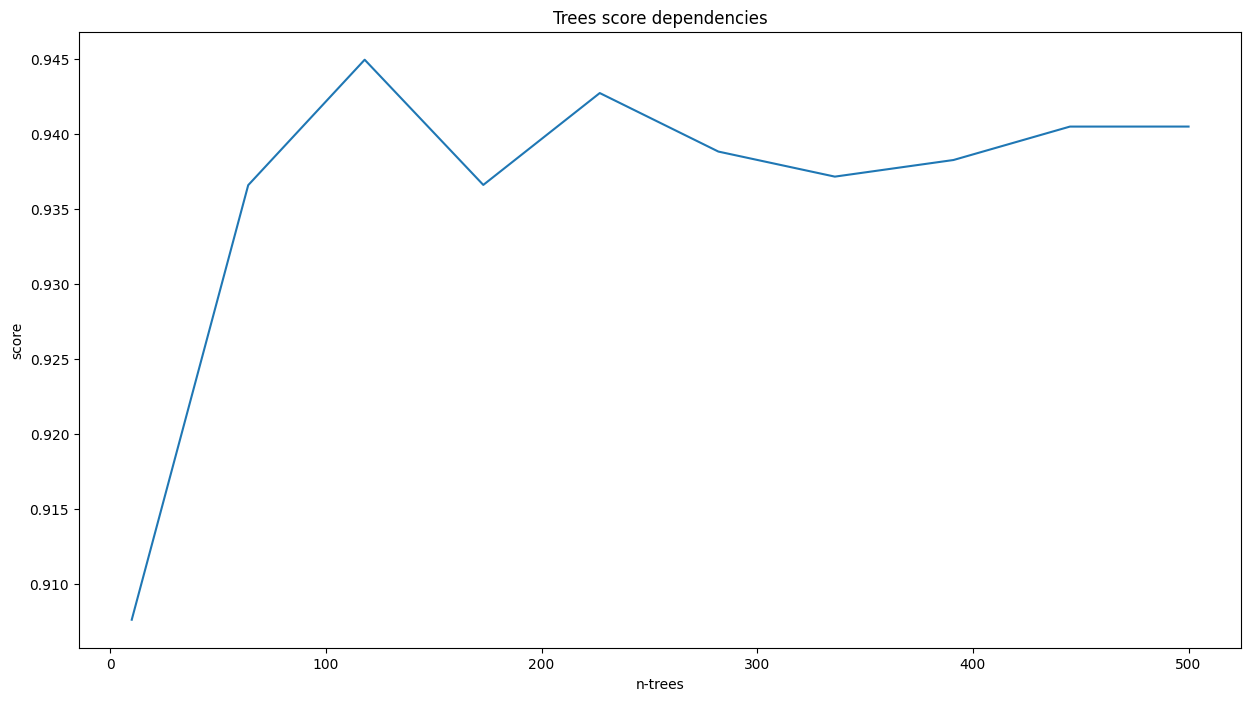

In [12]:
def plot_rf_trees_score():
    trees = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
    # trees = [100, 200, 300, 400, 500, 1000]
    results = []
    for tree in trees:
        rf = RandomForestClassifier(n_estimators=tree)
        results.append(get_accuracy(rf, X, y))
    plt.figure(figsize=(15, 8))
    plt.plot(trees, results)
    plt.xlabel("n-trees")
    plt.ylabel("score")
    plt.title("Trees score dependencies")
    plt.show()
plot_rf_trees_score()

Как правило, при использовании RF, качество обучения растет с ростом количества решающих деревьев. В какой-то момент деревьев ставноится достаточно для хорошего прогноза, а ошибка существенно не меняется с дальнейшим их увеличением

Посмотрим как зависит качетво от количетсва используемых признаков:

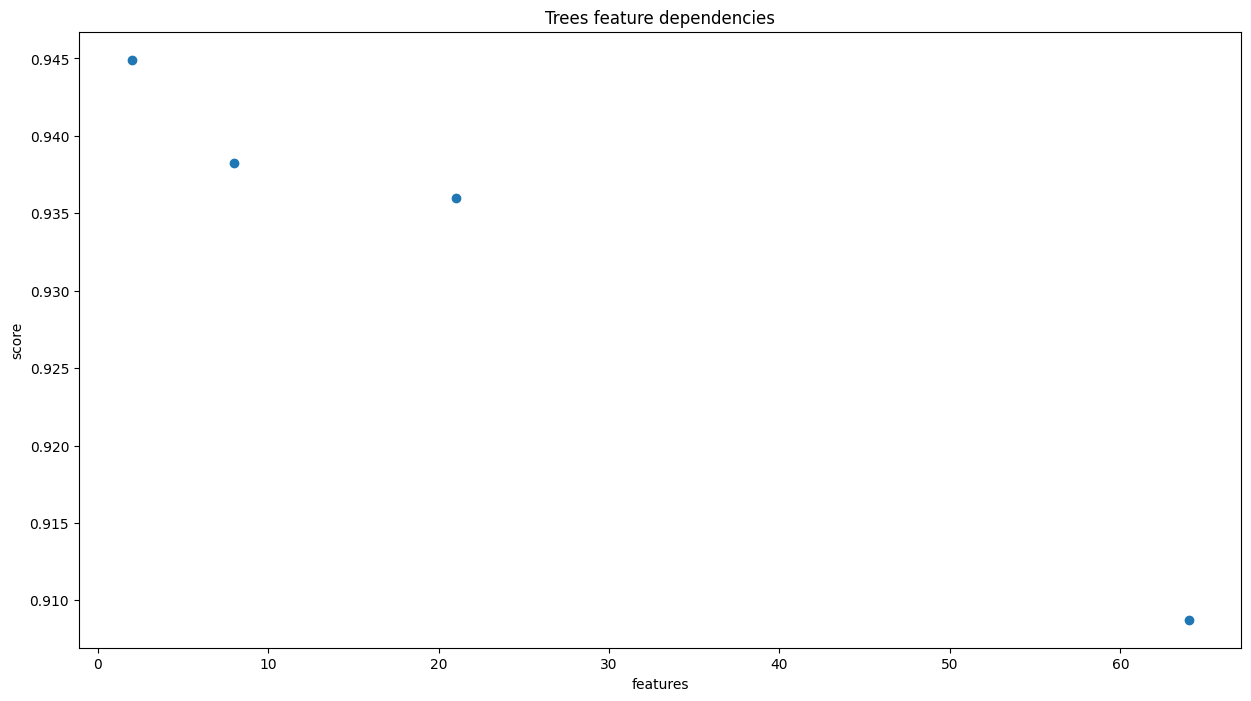

In [13]:
def plot_rf_trees_max_features():
    d = X.shape[1]
    features = [2, int(np.sqrt(d)), int(d/3), d]
    results = []
    for f in features:
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_features=f)
        results.append(get_accuracy(rf, X, y))
    plt.figure(figsize=(15, 8))
    plt.plot(features, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees feature dependencies")
    plt.show()
plot_rf_trees_max_features() 

При большом количестве признаков качество классификации становится хуже, чем при малом количестве признаков. Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция. Однако, стоит понимать, что при использовании очень малого количества признаков алгоритм не сможет установить зависимотси в данных.

Теперь посмотрим как влияет ограничение на глубину деревьев:

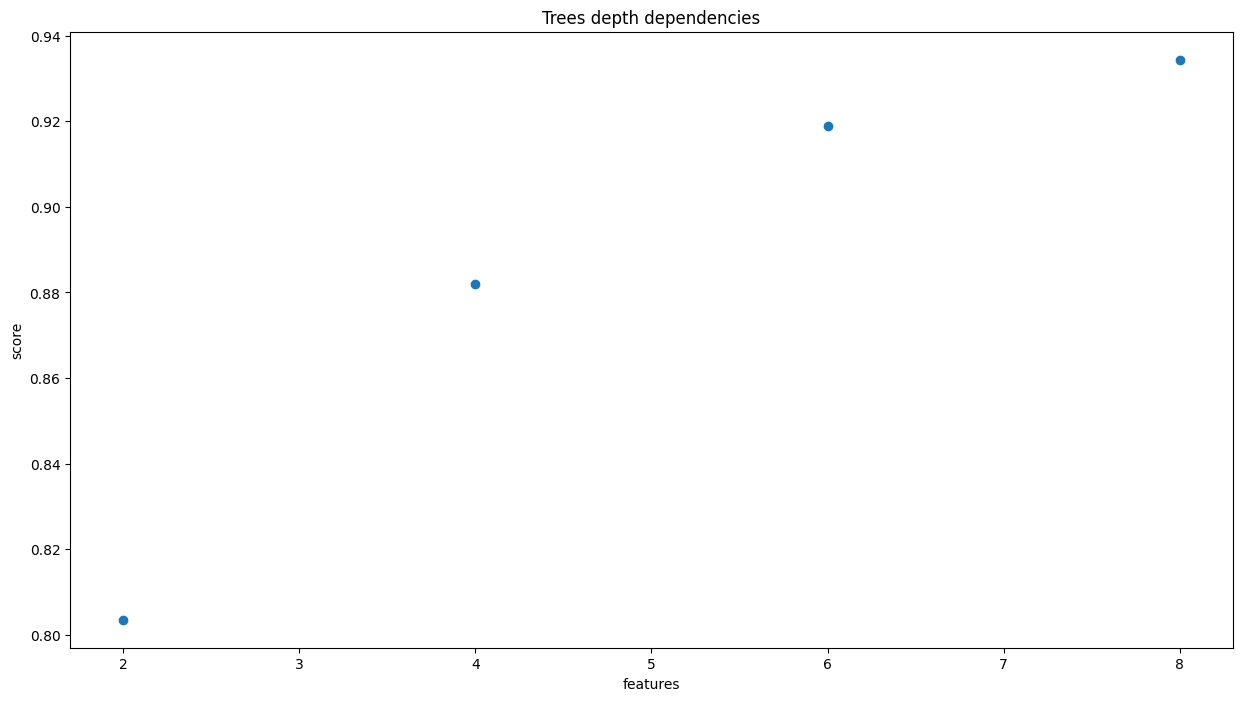

In [14]:
def plot_rf_tree_depth():
    d = X.shape[1]
    depth = [2, 4, 6, 8]
    results = []
    for d in depth:
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_depth=d)
        results.append(get_accuracy(rf, X, y))
    plt.figure(figsize=(15, 8))
    plt.plot(depth, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees depth dependencies")
    plt.show()
plot_rf_tree_depth() 

При небольшой максимальной глубине деревьев качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

Для построения бэггинга можно использовать любые другие базовые алгоритмы, например алгоритм логистической регрессии:

In [15]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)
lr.fit(X, y)
print("LR:", get_accuracy(lr, X, y))

LR: 0.9143160012380068


In [16]:
bagging_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    random_state=42
)
print("Bagging for LR:", get_accuracy(bagging_logreg, X, y))

Bagging for LR: 0.9215552460538532


# Бустинг

Бустинг  — метод построения ансамбля, в котором базовые алгоритмы не обучаются отдельно друг от друга, а каждый последующий правит ошибки предыдущего.  Бустинг позволяет улучшить точность прогнозирования путем преобразования слабых классификаторов в единую сильную модель.


Импортируем все необходимые для занятия библиотеки:

In [12]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

Попробуем решить задачу классификации c помощью бустинга, при этом сначала, вместо использования готового алгоритма из библиотеки sklearn, попробуем реализовать его самостоятельно.

Загрузим тестовый датасет из библиотеки sklearn:

In [13]:
diabetes = load_diabetes()
data, target = diabetes.data, diabetes.target

Разобъем данные на тренировочную и тестовую подвыборки:

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=0.8, shuffle=False)

Обучим последовательно 100 решающих деревьев, с максимальной глубиной 10. Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в направлении анти-градиента функции потерь. Так же, зададим постоянный коэффициент для каждого базового алгоритма

In [15]:
base_algorithms_list=[] # Список с базовыми алгоритмами
coefficients_list=[] # Список коэффициентов перед алгоритмами
error_list_train = [] # Список с значениями ошибки RMSE на тренировочной выборке
error_list_test = [] # Список с значениями ошибки RMSE на тестовой выборке

In [16]:
rate = 0.05
n_estimators = 100
max_depth_in = 10
random_state_in = 139

Создадим функцию для расчета прогноза на текущей итерации алгоритма:

In [17]:
def gbm_predict(X, base_algorithms_list, coefficients_list): 
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
    # base_algorithms_list — список с базовыми алгоритмами, 
    # coefficients_list — список с коэффициентами перед алгоритмами

Text(0, 0.5, 'Error')

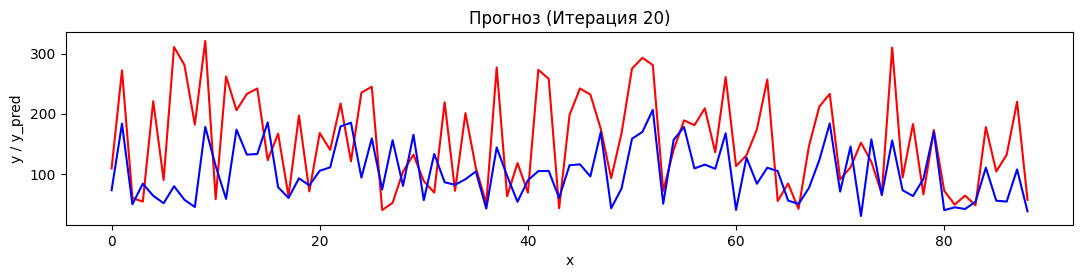

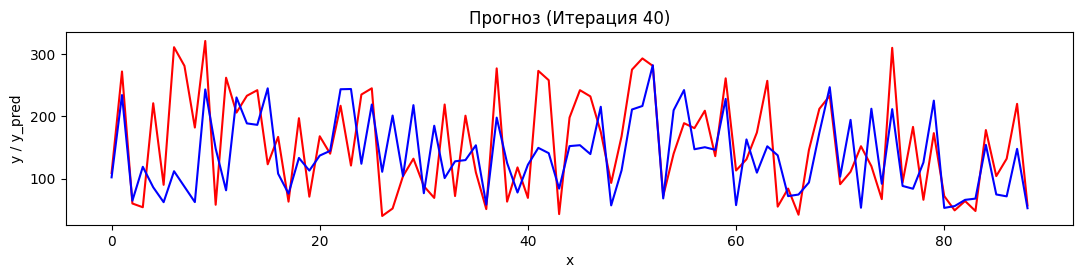

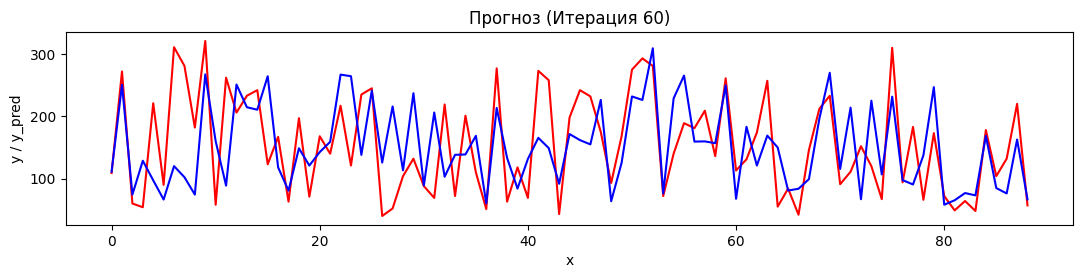

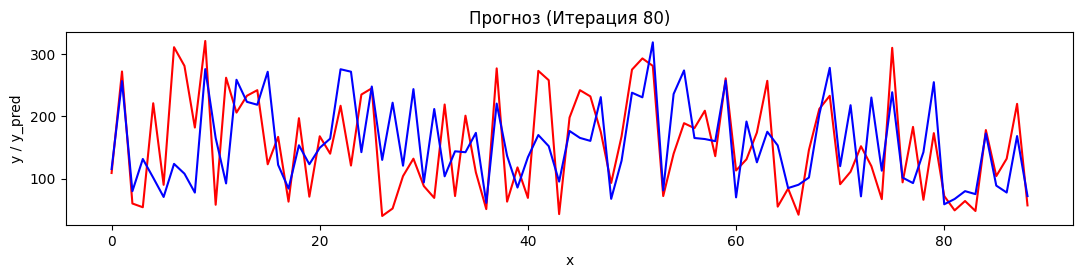

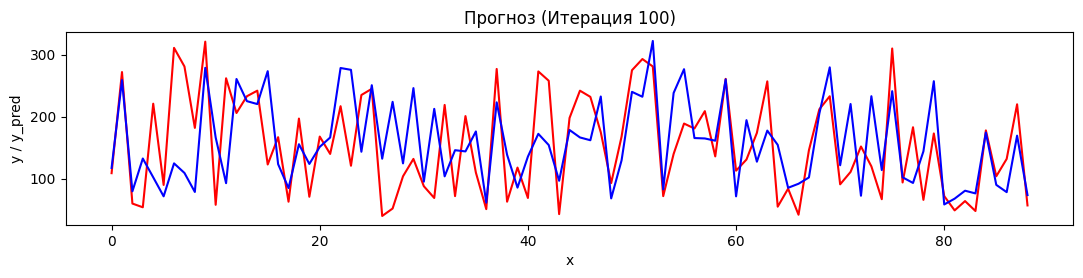

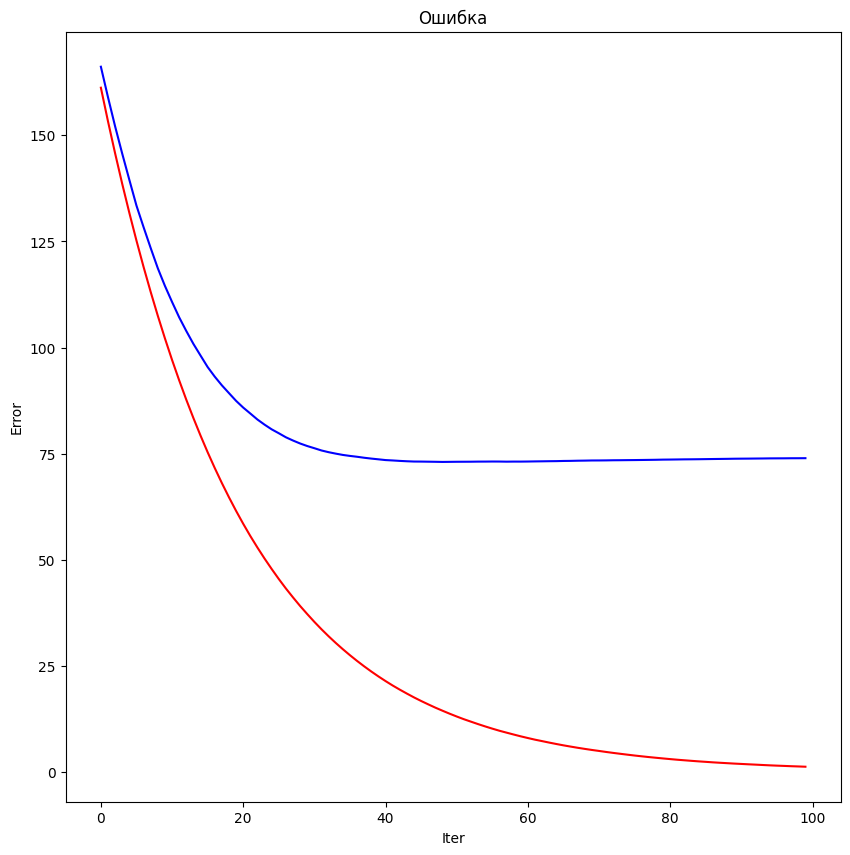

In [18]:
xi = x_train.copy()
yi = y_train.copy()

for cur_iter in range(n_estimators):
    regr = DecisionTreeRegressor(max_depth = max_depth_in, random_state = random_state_in)
    regr.fit(xi, yi)
    
    cur_coef = rate

    base_algorithms_list.append(regr)
    coefficients_list.append(cur_coef)

    y_pred_train = gbm_predict(xi, base_algorithms_list, coefficients_list)
    y_pred_test = gbm_predict(x_test, base_algorithms_list, coefficients_list)
    
    err_train_val = (mean_squared_error(y_train, y_pred_train))**(0.5)
    err_test_val = (mean_squared_error(y_test, y_pred_test))**(0.5)

    error_list_train.append(err_train_val)
    error_list_test.append(err_test_val)

    ei = (y_train - np.array(y_pred_train))
    yi = ei.copy()

    if(((cur_iter+1)%20) == 0):
        f, (ax1) = plt.subplots(1, 1, sharey=True, figsize = (13,2.5))
        ax1.plot(np.arange(len(y_test)),y_test, 'r-')
        ax1.plot(np.arange(len(y_pred_test)), y_pred_test, 'b-')
        ax1.set_title(f'Прогноз (Итерация {cur_iter+1})')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y / y_pred')

f, (ax1) = plt.subplots(1, 1, sharey=True, figsize = (10,10))
ax1.plot(np.arange(len(error_list_train)),np.array(error_list_train), 'r-')
ax1.plot(np.arange(len(error_list_test)),np.array(error_list_test), 'b-')
ax1.set_title(f'Ошибка')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Error')

In [19]:
print(error_list_train[-1])
print(error_list_test[-1])

1.275996168497968
73.94894679813767


Теперь создадим ансамбль из того же набора базовых алгоритмов с помощью метода GradientBoostingRegressor, реализованного в библиотеке sklearn:

In [20]:
learning_rate = 0.05
n_estimators = 100
max_depth_in = 10
random_state_in = 139

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(n_estimators = n_estimators, max_depth=max_depth_in, learning_rate = learning_rate, random_state=random_state_in)
reg.fit(x_train, y_train)
y_pred_xgb = reg.predict(x_test)

err_train_xgb = (mean_squared_error(y_test, y_pred_xgb))**(0.5)
err_train_xgb

74.54726407536243

# Стэкинг

Стекинг  — метод построения ансамбля, при котором агрегация ответов базовых алгоритмов осуществляется с помощью другого метода машинного обучения. При этом, такой вид ансамблей может объединять в себе базовые алгоритмы, принадлежащие различным семействам. 

Импортируем все необходимые для занятия библиотеки:

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

Попробуем решить задачу классификации c помощью стекинга, при этом сначала, вместо использования готового алгоритма из библиотеки sklearn, попробуем реализовать его самомтоятельно. Для этого необходимо последовательно проделать следуещие шаги:

1) Разбить исходную выборку на две части – тренировочная/тестовая
2) Обучающую выборку разбить на N частей (фолдов)
3) Последовательно перебирать все фолды. Обучить базовые модели на всех фолдах кроме текущего, на котором далее получить прогноз базовых алгоритмов 
4) Полученный прогноз использовать в качестве данных для обучения мета-алгоритма
5) Примененить мета-алгоритм к метапризнакам тестовой подвыборки

In [25]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target

Разобъем данные на тренировочную и тестовую подвыборки:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

Нормируем данные перед обучением:

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Реализуем две функции, которые позволяют последовательно обучить набор базовых алгоритмов на тренировочной подвыборке и получить прогноз - на котором будем обучать мета-алгоритм.

'generate_meta_features' - перебирает все базовые алгоритмы, с помощью последовательного вызова функции'compute_meta_feature' и объединяет полученные результаты


'compute_meta_feature' - разбивает тренировочную подвыборку на фолды, на котрых обучается один входной базовый алгоритм. 

! В данном случае для формирования тестовой подвыборки для мета-алгоритма (X_meta_test) мы заново обучаем каждый базовый алгоритм на всей исходной тренировочной подвыборке (X_test)

In [28]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Входный данные:

    clf: текущий классификатор
    X_train, y_train: тренировочная подвыборка
    X_test: тестовая подвыборка
    cv: объект KFold, содержащий информацию о разбиении на фолды

    Выходные данные:

    X_meta_train - новый признак для обучения мета-алгоритма (прогноз текущего базового алгоритма на n-фолдах)
    X_meta_test - новый признак для тестирования мета-алгоритма (прогноз текущего базового алгоритма)

    """

    # Выходной массив, содержащий прогноз текущего базового алгоритма
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    # Последовательное разбиение тренировочной подвыборки на фолды
    for train_fold_index, predict_fold_index in cv.split(X_train):
        # Выделение текущего фолда
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        # Обучение базового алгоритма на текущем фолде
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        # Получение прогноза на текущем фолде и добавление результата в итоговый массив
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    # Формирование тестовой выборки для мета-алгоритма - X_meta_test
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [29]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Входный данные:

    classifiers: набор базовых классификаторов
    X_train, y_train: тренировочная подвыборка
    X_test: тестовая подвыборка
    cv: объект KFold, содержащий информацию о разбиении на фолды

    Выходные данные:

    stacked_features_train - набор признаков для обучения мета-алгоритма
    stacked_features_test - набор признаков для тестирования мета-алгоритма
    """

    # Последовательная отработка каждого базового алгоритма
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    ## Объединение результатов каждого юазового алгоритма
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

Для разбиения данных воспользуемся классом KFold. Будем использовать 10 фолдов.

В качестве базовых алгоритмов используем следующий набор:

1) логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'liblinear', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000

2) логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000

3) случайный лес из 300 деревьев

4) градиентный бустинг из 200 деревьев

In [30]:
cv = KFold(n_splits=10, shuffle=True)

estimators = [
    LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=2000, multi_class='ovr',random_state=42),
    LogisticRegression(C=0.001, penalty='l2', solver='saga', max_iter=2000, multi_class='multinomial',random_state=42),  
    RandomForestClassifier(n_estimators=300, random_state=42),
    GradientBoostingClassifier(n_estimators=200, random_state=42)
]

stacked_features_train, stacked_features_test = generate_meta_features(estimators, X_train, X_test, y_train, cv)

100%|██████████| 4/4 [00:18<00:00,  4.64s/it]


Добавим полученные признаки к исходному набору тренировочных и тестовых данных:

In [31]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

В качестве мета-алгоритма будем использовать алгоритм логистической регрессии:

In [32]:
np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='sag')
clf.fit(stacked_features_train, y_train)
accuracy_score(clf.predict(stacked_features_test), y_test)

/home/skg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.8518518518518519

Теперь создадим ансамбль из того же набора базовых алгоритмов с помощью метода StackingClassifier, реализованного в библиотеке sklearn:

In [33]:
estimators = [('lr_1', LogisticRegression(C=0.001, penalty='l1', solver='saga', max_iter=2000, multi_class='ovr',random_state=42)), 
                ('lr_2', LogisticRegression(C=0.001, penalty='l2', solver='saga', max_iter=2000, multi_class='multinomial',random_state=42)),
                ('RF', RandomForestClassifier(n_estimators=300, random_state=42)),
                ('GB', GradientBoostingClassifier(n_estimators=200, random_state=42))]
meta_clf = LogisticRegression(penalty='none', solver='sag')
modelClf = StackingClassifier(estimators=estimators, cv=5, final_estimator=meta_clf)

In [34]:
modelClf.fit(X_train, y_train)

accuracy_score(modelClf.predict(X_test), y_test)

/home/skg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9814814814814815

Метод принимает следующие настроечные параметры:
___
- estimatorslist (str, estimator)

Список базовых алгоритмов из которых будет составлен ансамбль
___
- final_estimatorestimator (default=None)

Мета-алгоритм который будет использован для получения итогового прогноза. По умолчанию используется метод логистической регрессии
___
- cvint, cross-validation generator, iterable, or “prefit” (default=None)

Определяет разбиение разбиение выборки для кросс-валидации. 

По умолчанию выборка разбивается на 5 фолдов с равномерным распределением классов (StratifiedKFold)

Целое число - задает количество фолдов при использовании StratifiedKFold
___
- stack_method{‘auto’, ‘predict_proba’, ‘decision_function’, ‘predict’}, default=’auto’

Методы, вызываемые для каждой базовой оценки. Может быть:

если «авто», он попытается вызвать для каждой оценки «predict_proba», «decision_function» или «predict» в указанном порядке.

в противном случае одно из «predict_proba», «decision_function» или «predict». Если метод не реализован оценщиком, он вызовет ошибку.
___
- n_jobs int, default=None

Количество задач, которые должны выполняться параллельно. По умолчанию = 1

-1 означает использование всех процессоров
___

- passthroughbool (default=False)

При значении False в качестве обучающих данных для final_estimator будут использоваться только прогнозы базовых алгоритмов. Когда True, final_estimator обучается на прогнозах базовых алгоритмов, а также на исходных данных как в созданном нами примере.
___